In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
from glob import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [3]:
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.models import Sequential, Model


In [ ]:
!zip -r file.zip /content/drive/MyDrive/dataset/paragraph

  adding: content/drive/MyDrive/dataset/paragraph/ (stored 0%)
  adding: content/drive/MyDrive/dataset/paragraph/59.jpg (deflated 1%)


In [ ]:
!ls

sample_data


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from IPython.display import FileLink
FileLink(r'file.zip')

/content/file.zip

In [6]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory

    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory

    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'

    Returns
    _____
    Crzip_dir()eates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)


In [ ]:
zip_dir()

# Preprocessing Images

Total images in dataset: 19551


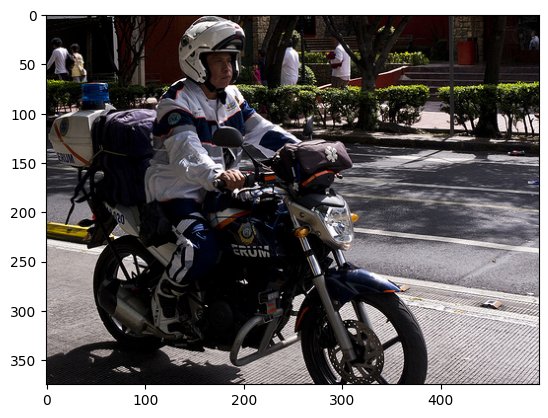

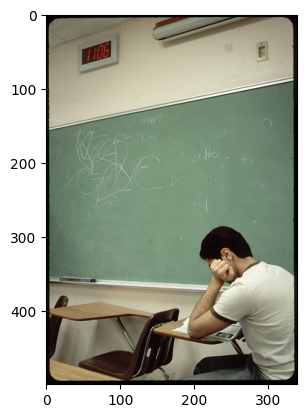

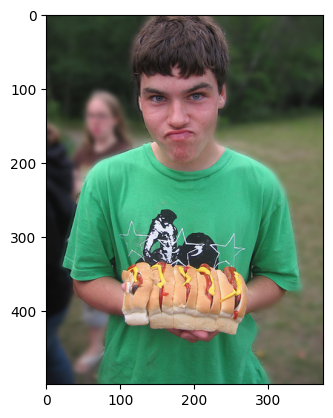

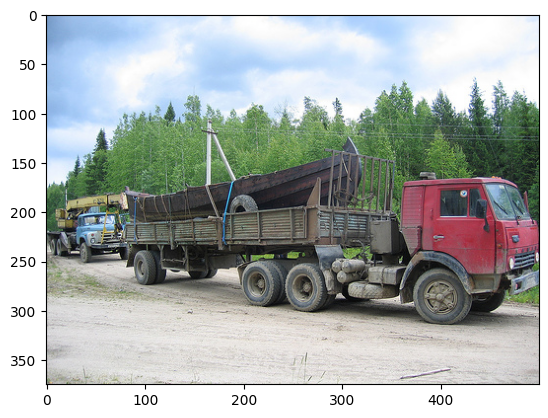

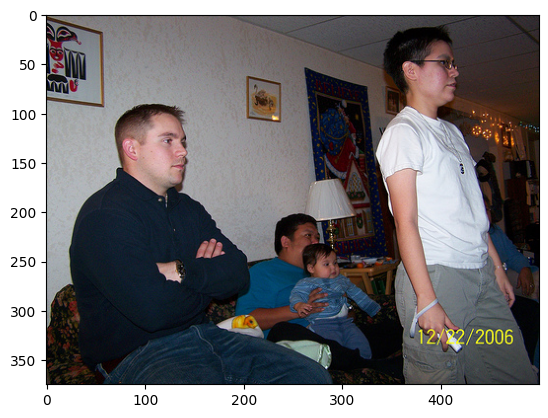

In [7]:
images_path = '/content/drive/MyDrive/dataset/stanford_img/content/stanford_images/'
images = glob(images_path+'*.jpg')
print("Total images in dataset:",len(images))
for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [8]:
incept_model = ResNet50(include_top=True)
last = incept_model.layers[-2].output
CNNmodel = Model(inputs = incept_model.input,outputs = last)

In [ ]:
images_features = {}
count = 0
print("Converting images to features using CNN model")
for i in images:
   img = cv2.imread(i)
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   img = cv2.resize(img, (224,224))
   img = img.reshape(1,224,224,3)
   pred = CNNmodel.predict(img).reshape(2048,)
   img_name = i.split('/')[-1]
   images_features[img_name] = pred
   print(img_name)
   count += 1
   if count % 500 == 0:
       print("Completed for "+str(count)+" images")
print("length of image features:",len(images_features))
list(images_features.items())[:5]

Converting images to features using CNN model
1/1 [==============================] - 2s 2s/step
2413416.jpg
1/1 [==============================] - 0s 337ms/step
2413427.jpg
1/1 [==============================] - 0s 374ms/step
2413431.jpg
1/1 [==============================] - 0s 324ms/step
2413436.jpg
1/1 [==============================] - 0s 342ms/step
2413437.jpg
1/1 [==============================] - 0s 351ms/step
2413451.jpg
1/1 [==============================] - 0s 356ms/step
2413457.jpg
1/1 [==============================] - 0s 365ms/step
2413458.jpg
1/1 [==============================] - 0s 210ms/step
2413461.jpg
1/1 [==============================] - 0s 205ms/step
2413464.jpg
1/1 [==============================] - 0s 196ms/step
2413465.jpg
1/1 [==============================] - 0s 214ms/step
2413480.jpg
1/1 [==============================] - 0s 216ms/step
2413487.jpg
1/1 [==============================] - 0s 206ms/step
2413499.jpg
1/1 [==============================] - 0s 207ms

In [ ]:
import pickle

with open("/content/drive/MyDrive/dataset/stanford_img/pickle/images_features.pkl","wb") as f:
   pickle.dump(images_features , f)


with open("/content/drive/MyDrive/dataset/stanford_img/pickle/images_features.pkl","rb") as f:
    images_features=pickle.load(f)


# Preprocessing Captions and Creating Vocabulary

In [ ]:
caption_path = '/content/drive/MyDrive/dataset/stanford_img/stanford dataset_nepali.csv'

with open(caption_path) as csvfile:
    captions=csv.reader(csvfile, delimiter=',', quotechar='"')
    captions_dict_train,captions_dict_test,captions_dict_val= {},{},{}
    for i in captions:
        try:
            img_name = i[0]  + ".jpg"
            caption = i[1]
            train_input=i[2]
            test_input=i[3]
            val_input=i[5]
            if img_name in images_features:
                if train_input=='True':
                    captions_dict_train[img_name] = caption
                elif test_input=='True':
                    captions_dict_test[img_name] = caption
                elif val_input=='True':
                    captions_dict_val[img_name] = caption
        except:
            pass

print("size of train, test and validation dataset:" ,len(captions_dict_train),len(captions_dict_test),len(captions_dict_val))

size of train, test and validation dataset: 14575 2489 2487


**I am Testing this module picewise**

In [ ]:
# spelling check in nepali
# coding: utf-8
import os
import sys
sys.path.append('..')
from spello.model import SpellCorrectionModel

from difflib import get_close_matches

class Corrector:
    """This function correct the Nepali word based on distance of character.

    """
    def __init__(self):
        self.this_dir, self.this_file = os.path.split(__file__)
        self.sp = SpellCorrectionModel(language='hi').load(os.path.join(self.this_dir, "local_dataset", "spell_model.pkl"))



    def __load_words(self,location):
        """This function load all the Nepali words in given location.

        Arguments:
            location {string} -- [Location where vocabulary is located please be sure to indicate name and extension also.]

        Returns:
            [list] -- [List of all Nepali word]
        """
        file = open(os.path.join(self.this_dir,"local_dataset", location), 'r')
        text = file.read()
        text = text.split()
        file.close()
        return text

    def corrector(self,word,location ='words.txt',number=2, threshold = 0.3):
        """This functon returns 'n' number of correct words.

        Arguments:
            word {string} -- [Word you want to check for spelling.]

        Keyword Arguments:
            location {str} -- [Location of Vocabulary file with name and extension.] (default: {'../local_dataset/words.txt'})
            number {int} -- [Number of close correct words.] (default: {2})
            threshold {float} -- [Threshold distance between words enter and predicted word'.] (default: {0.3})

        Returns:
            [list] -- ['n' correct word predictions.]
        """
        word_list = self.__load_words(location)
        matches = get_close_matches(word, word_list, n=2, cutoff=0.3)

        return matches

    def spell_correct(self, text):
        """
        Returns the spell corrected string based on context, phoneme

        Arguments:
            text {str} -- Text in Nepali

        Returns:
            Dict -- dictionary with correct word, input text and correction text.
        """
        return self.sp.spell_correct(text)

In [ ]:
#Nepali preprocessing
#tokenizer
import os
import sys
sys.path.append('..')
import string

import tensorflow as tf
import sentencepiece as spm

class Tokenizer:
    def __init__(self):
        self.this_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()

    def sentence_tokenize(self, text):
        """This function tokenize the sentences

        Arguments:
            text {string} -- Sentences you want to tokenize

        Returns:
            sentence {list} -- tokenized sentence in list
        """
        sentences = text.strip().split("।")
        sentences = [sentence.translate(str.maketrans('', '', string.punctuation)) for sentence in sentences]
        return sentences

    def word_tokenize(self, sentence, new_punctuation=[]):
        """This function tokenize with respect to word

        Arguments:
            sentence {string} -- sentence you want to tokenize
            new_punctuation {list} -- more punctutaion for tokenizing  default ['।',',',';','?','!','—','-']

        Returns:
            list -- tokenized words
        """
        punctuations = ['।', ',', ';', '?', '!', '—', '-', '.']
        if new_punctuation:
            punctuations = set(punctuations + new_punctuation)

        for punct in punctuations:
            sentence = ' '.join(sentence.split(punct))

        return sentence.split()

    def character_tokenize(self, word):
        """ Returns the tokenization in character level.

        Arguments:
            word {string} -- word to be tokenized in character level.

        Returns:
            [list] -- list of characters.
        """
        try:
            import icu

        except:
            print("please install PyICU")

        temp_ = icu.BreakIterator.createCharacterInstance(icu.Locale())
        temp_.setText(word)
        char = []
        i = 0
        for j in temp_:
            s = word[i:j]
            char.append(s)
            i = j

        return char

    def sentencepeice_tokenize(self, text):
        """unsupervised way of tokenizing the text using google sentencepiece library. More info at https://github.com/google/sentencepiece

        Args:
            text (string): Text in Nepali language

        Returns:
            list: tokenized words.
        """
        try:
            model = tf.gfile.Gfile(os.path.join(self.this_dir, "local_dataset", "m_bpe.model"), "rb").read() #tf version 1
        except:
            model = tf.io.gfile.GFile(os.path.join(self.this_dir, "local_dataset", "m_bpe.model"), "rb").read() #tf version 2
        sp = spm.SentencePieceProcessor()
        sp.load_from_serialized_proto(model)
        return sp.encode_as_pieces(text)


    def __str__(self):
        return "Helps to tokenize content written in Nepali language."

In [ ]:
# Not very useful

In [ ]:
def handle_nepali_characters(text):
    # Assuming the text is already in Unicode format
    return text

import re

def remove_special_characters(text):
    # Remove non-alphanumeric characters except for spaces
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text


In [ ]:
from nltk.corpus import stopwords

def remove_nepali_stopwords(words):
    nepali_stopwords = set(stopwords.words("nepali"))
    return [word for word in words if word not in nepali_stopwords]


In [ ]:
# stemming and stop word
import sys
sys.path.append('..')

import ast
from .Nepali_tokenizer import Tokenizer


class Stopwords:
    """This class helps in removing Nepali stopwords."""
    def __init__(self):
        pass

    def remove_stopwords(self,text):
        """This function remove stopwords from text

        Arguments:
        sentence {string} -- sentence you want to remove stopwords
        Returns:
            list -- token words
        """
        f = open("local_dataset/stopword1.txt",'r')
        stopwords = f.read()
        stopwords = ast.literal_eval(stopwords)
        tokenizer = Tokenizer()
        token = tokenizer.word_tokenize(text)
        word_without_stopword=[]
        for word in token:
            if word not in stopwords:
                word_without_stopword.append(word)

        return word_without_stopword



Original Code


In [ ]:
def preprocessed(txt):
    modified = txt.lower().replace('.',' .').replace("'","")
    modified = 'startofseq ' + modified + ' endofseq'
    return modified

count_words = {}
print("Captions before preprocessing\n ",list(captions_dict_train.items())[:5])

for k,v in captions_dict_train.items():
    captions_dict_train[k]=preprocessed(v)

#creating count_words dict with word and frequency
for k,v in captions_dict_train.items():
    for word in v.split():
        if word not in count_words:
            count_words[word] = 1
        else:
            count_words[word] += 1

#creating words_dict as vocabulary where only words occuring more than threshold is considered
THRESH = 5
count = 1
words_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        words_dict[k] = count
        count += 1

#captions_dict converting words into numbers from words_dict
for k, v in captions_dict_train.items():
    encoded = []
    for word in v.split():
        if word in words_dict.keys():
            encoded.append(words_dict[word])

    captions_dict_train[k] = encoded

print("Captions after preprocessing\n ",list(captions_dict_train.items())[:5])

Captions before preprocessing
  [('2317429.jpg', 'एउटा सेतो गोलो प्लेट एउटा टेबलमा छ जसमा प्लास्टिकको कपडा छ। सेतो प्लेटमा सुनको पहेँलो फ्रेन्च फ्राइजको परिकारसँगै पन्नीले ढाकिएको खानाको दुई भागहरू छन्। छोटो, टपलेस, प्लास्टिक कन्टेनरमा सेतो प्लेटको छेउमा सेतो चटनी छ। सेतो प्लेटमा विकर्ण धेरै अन्य स्ट्याक्ड प्लेटहरूको किनारहरू हुन्। कालो छायाहरू टेबलमा प्रतिबिम्बित छन्।'), ('2365091.jpg', 'एउटा ठुलो रातो र सेतो रेलले ग्रामीण क्षेत्र जस्तो देखिने ट्र्याकमा यात्रा गरिरहेको छ। पृष्ठभूमिमा रूख र पहाडहरू छन् र जमिन सुख्खा देखिन्छ। यात्रुहरूलाई बाहिर हेर्नको लागि ट्रेनमा धेरै ठूला झ्यालहरू छन्। ट्रेनको अगाडिको माथिल्लो भागमा रातो र छेउमा रातो पट्टी र ट्रिमको साथ प्रायः सेतो हुन्छ। रेलको छाना खरानी छ।'), ('2383120.jpg', 'धेरै सफा र सफा बाथरूम। सबै चीज सफा पोर्सिलेन सेतो छ। यो बाथरूम रेट्रो र आधुनिक दुवै छ।'), ('2333990.jpg', 'खैरो काठको प्लेटमा चारवटा साना पिज्जाहरू छन्। गार्निशको लागि केन्द्रमा सागहरू छन्। साना पिज्जाहरूमा ब्रोकोली, रातो मिर्च र टपिङका लागि चीज हुन्छ। काठको थाल सेतो टेबलमा बस

Original Code


In [ ]:
import pickle

with open("/content/drive/MyDrive/dataset/stanford_img/pickle/words_dict.pkl", "wb") as f:
   pickle.dump(words_dict , f)


# Merge Model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 192)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 192, 192)             1044672   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

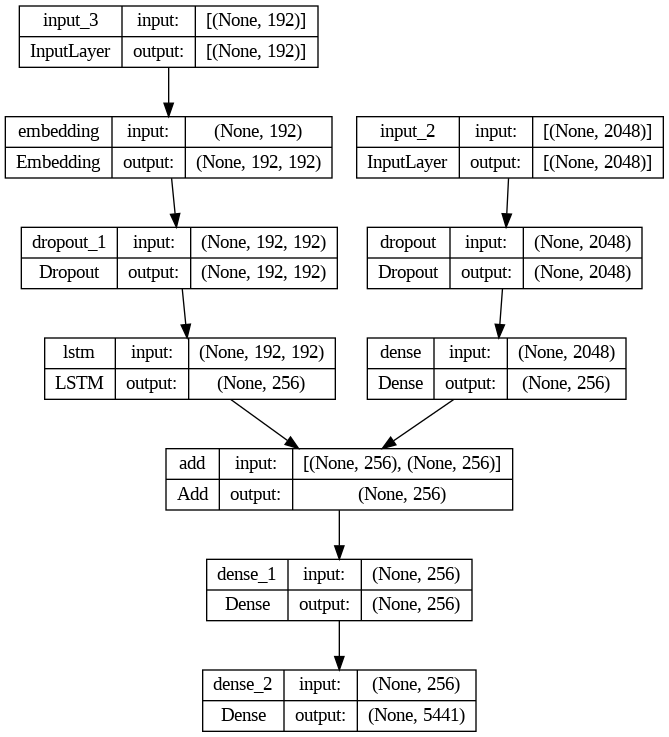

In [ ]:

vocab_size = len(words_dict)+1
MAX_LEN = 0

for k, v in captions_dict_train.items():
    if len(v) > MAX_LEN:
        MAX_LEN = len(v)

# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# language sequence model
inputs2 = Input(shape=(MAX_LEN,))
se1 = Embedding(vocab_size, MAX_LEN, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# summarize model
model.summary()
plot_model(model, show_shapes=True)


# Training RNN- Using Generator Function to create input

In [ ]:
N=32 #BatchSize
VOCAB_SIZE = len(words_dict)+1

def progressive_generator(photo_dict, caption_dict, MAX_LEN,VOCAB_SIZE):
    while 1:
        for i in range(0,len(caption_dict),N):
            caption = dict(list(caption_dict.items())[0+i: N+i])
            X, y_in, y_out = create_sequences(photo_dict,caption,MAX_LEN, VOCAB_SIZE)
            yield [X, y_in], y_out


def create_sequences(photo, caption, MAX_LEN,VOCAB_SIZE):
    #n_samples = 0
    X,y_in,y_out = [],[],[]

    for k, v in caption.items():
        for i in range(1, len(v)):
            X.append(photo[k])

            in_seq= [v[:i]]
            out_seq = v[i]

            in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
            out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

            y_in.append(in_seq)
            y_out.append(out_seq)

    return np.array(X), np.array(y_in), np.array(y_out)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Define the checkpoint filepath
checkpoint_filepath = '/content/drive/MyDrive/dataset/stanford_img/pickle/image_caption_model_newarch50_checkpoint.h5'

# Create ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    save_weights_only=False,  # Save the entire model, including architecture and optimizer state
    save_best_only=True,  # Save only if the model is the best so far
    monitor='loss',  # Monitor the training loss
    mode='min',  # Mode for monitoring (minimize the loss)
    verbose=1  # Print messages
)

# Calculate steps per epoch
steps = len(captions_dict_train) // N

# Create and compile the model
generator = progressive_generator(images_features, captions_dict_train, MAX_LEN, VOCAB_SIZE)
model.compile(optimizer='your_optimizer', loss='your_loss', metrics=['your_metrics'])

# Fit the model with the generator and use the ModelCheckpoint callback
model.fit(generator, epochs=50, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint])

# Save the final model
model.save('/content/drive/MyDrive/dataset/stanford_img/pickle/image_caption_model_newarch50_final.h5')


In [ ]:


# Load the model from the checkpoint file
loaded_model = load_model('./image_caption_model_newarch50_checkpoint.h5')

# Continue training the loaded model if needed
loaded_model.fit(generator, epochs=remaining_epochs, steps_per_epoch=remaining_steps, verbose=1, callbacks=[checkpoint])

# Save the final model
loaded_model.save('/content/drive/MyDrive/dataset/stanford_img/pickle/image_caption_model_newarch50_final.h5')


original


In [ ]:
checkpoint =ModelCheckpoint('./image_caption_model_epoch_{epoch}.h5', monitor='val_loss', save_best_only=True)

In [ ]:
steps = len(captions_dict_train)/N
generator = progressive_generator(images_features, captions_dict_train, MAX_LEN, VOCAB_SIZE)
model.fit(generator, epochs=50, steps_per_epoch=steps, verbose=1,callbacks=[checkpoint])
model.save('/content/drive/MyDrive/dataset/stanford_img/pickle/image_caption_model_newarch50' + '.h5')

Epoch 1/50
  3/455 [..............................] - ETA: 1:41:37 - loss: 8.3415 - accuracy: 0.0390

In [ ]:
from IPython.display import FileLink
FileLink(r'./words_dict.pkl')

#  Prediction

In [ ]:
vocab_size = len(words_dict)+1
MAX_LEN = 0

for k, v in captions_dict_train.items():
    if len(v) > MAX_LEN:
        MAX_LEN = len(v)

inv_dict = {v:k for k, v in words_dict.items()}

In [ ]:
## For selected test images

#2373586.jpg 75 epoch
#2361833.jpg 75 epoch

#2394335.jpg 150 epoch
#2364210.jpg 150 epoch
#2402430.jpg 2395361.jpg 150 epoch
#2335374.jpg 2373374.jpg 150 epoch


model = tf.keras.models.load_model('/content/image_caption_model_newarch50.h5')
# img_name='01659403106.jpg'
# test_feature = images_features[img_name]
test_img_path = '/content/drive/MyDrive/dataset/stanford_img/content/stanford_images/2413416.jpg'
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


text_inp = ['startofseq']
count = 0
caption = ''
while count < MAX_LEN:
    count += 1
    encoded = []
    for i in text_inp:
        encoded.append(words_dict[i])
    encoded = [encoded]
    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
    data_list=[np.array(test_feature).reshape(1,-1), np.array(encoded).reshape(1,-1)]
    prediction = np.argmax(model.predict(data_list))
    sampled_word = inv_dict[prediction]
    caption = caption + ' ' + sampled_word

    if sampled_word == 'endofseq':
        break
    text_inp.append(sampled_word)

caption= caption.replace('endofseq','')
predicted= caption.split()
# actual= captions_dict_test[img_name].split()

# blueScore= sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

# print('BLEU-1: %f' % sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print('BLEU-2: %f' % sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
# print('BLEU-3: %f' % sentence_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
# print('BLEU-4: %f' % sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

plt.figure()
plt.imshow(test_img)
# plt.title(img_name+" - BLUE Score: "+str(blueScore))
plt.show()
print(caption.replace(' .','.'))

In [ ]:
model = tf.keras.models.load_model('/content/image_caption_model_newarch50.h5')
# img_name='01659403106.jpg'
# test_feature = images_features[img_name]
test_img_path = '/content/drive/MyDrive/dataset/stanford_img/content/stanford_images/291.jpg'
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


text_inp = ['startofseq']
count = 0
caption = ''
while count < MAX_LEN:
    count += 1
    encoded = []
    for i in text_inp:
        encoded.append(words_dict[i])
    encoded = [encoded]
    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
    data_list=[np.array(test_feature).reshape(1,-1), np.array(encoded).reshape(1,-1)]
    prediction = np.argmax(model.predict(data_list))
    sampled_word = inv_dict[prediction]
    caption = caption + ' ' + sampled_word

    if sampled_word == 'endofseq':
        break
    text_inp.append(sampled_word)

caption= caption.replace('endofseq','')
predicted= caption.split()
# actual= captions_dict_test[img_name].split()

# blueScore= sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

# print('BLEU-1: %f' % sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print('BLEU-2: %f' % sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
# print('BLEU-3: %f' % sentence_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
# print('BLEU-4: %f' % sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

plt.figure()
plt.imshow(test_img)
# plt.title(img_name+" - BLUE Score: "+str(blueScore))
plt.show()
print(caption.replace(' .','.'))

In [ ]:
## For selected test images

#2373586.jpg 75 epoch
#2361833.jpg 75 epoch

#2394335.jpg 150 epoch
#2364210.jpg 150 epoch
#2402430.jpg 2395361.jpg 150 epoch
#2335374.jpg 2373374.jpg 150 epoch


model = tf.keras.models.load_model('../input/imagecaptioningmodels/image_caption_model_newarch150.h5')
img_name='2364210.jpg'
test_feature = images_features[img_name]
test_img_path = '../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/'+img_name
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


text_inp = ['startofseq']
count = 0
caption = ''
while count < MAX_LEN:
    count += 1
    encoded = []
    for i in text_inp:
        encoded.append(words_dict[i])
    encoded = [encoded]
    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
    data_list=[np.array(test_feature).reshape(1,-1), np.array(encoded).reshape(1,-1)]
    prediction = np.argmax(model.predict(data_list))
    sampled_word = inv_dict[prediction]
    caption = caption + ' ' + sampled_word

    if sampled_word == 'endofseq':
        break
    text_inp.append(sampled_word)

caption= caption.replace('endofseq','')
predicted= caption.split()
actual= captions_dict_test[img_name].split()

blueScore= sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

print('BLEU-1: %f' % sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % sentence_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

plt.figure()
plt.imshow(test_img)
plt.title(img_name+" - BLUE Score: "+str(blueScore))
plt.show()
print(caption.replace(' .','.'))

In [ ]:
# Assuming you have the CNNmodel and images as defined earlier

images_feature = {}
count = 0
print("Converting images to features using CNN model")

# Iterate over the first three images
for i in images[:3]:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.reshape(1, 224, 224, 3)
    pred = CNNmodel.predict(img).reshape(2048,)
    img_name = i.split('/')[-1]
    print(img_name)
    images_feature[img_name] = pred
    count += 1

    if count % 1 == 0:
        print("Completed for " + str(count) + " images")

print("Length of image features:", len(images_feature))
print("Features for the first 5 images:")
for img_name, features in list(images_feature.items())[:5]:
    print(f"Image: {img_name}, Features: {features}")



In [ ]:
## For random test images

model = tf.keras.models.load_model('/content/image_caption_model_newarch50.h5')

plt.figure()
for i in range(3):

    num=  np.random.randint(0,len(captions_dict_test))
    img_name=['2413431.jpg','2413427.jpg','2413416.jpg']
    test_feature = images_feature[img_name]
    test_img_path = '../input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/'+img_name

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < MAX_LEN:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(words_dict[i])

        encoded = [encoded]
        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
        data_list=[np.array(test_feature).reshape(1,-1), np.array(encoded).reshape(1,-1)]
        prediction = np.argmax(model.predict(data_list))
        sampled_word = inv_dict[prediction]
        caption = caption + ' ' + sampled_word

        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)

    caption= caption.replace('endofseq','')
    predicted= caption.split()
    actual= captions_dict_test[img_name].split()

    blueScore= sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    plt.imshow(test_img)
    plt.title(img_name+" - BLUE Score: "+str(blueScore))
    plt.show()
    print(caption.replace(' .','.') )
    print('BLEU-1: %f' % sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % sentence_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))



In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu

# Assuming you have the necessary definitions for MAX_LEN, words_dict, inv_dict, images_features, captions_dict_test

# List of image names to process
img_names = ['2413431.jpg', '2413427.jpg', '2413416.jpg']

plt.figure()

for img_name in img_names:
    test_feature = images_features[img_name]
    test_img_path = '/content/drive/MyDrive/dataset/stanford_img/content/stanford_images/' + img_name

    # Load the image properly and handle any errors
    try:
        test_img = cv2.imread(test_img_path)
        if test_img is None:
            raise FileNotFoundError("Image not found or could not be read")

        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading image '{img_name}': {str(e)}")
        continue

    text_inp = ['startofseq']
    count = 0
    caption = ''

    while count < MAX_LEN:
        count += 1
        encoded = [words_dict.get(word, 0) for word in text_inp]
        encoded = [encoded]
        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
        data_list = [np.array(test_feature).reshape(1, -1), np.array(encoded).reshape(1, -1)]
        prediction = np.argmax(model.predict(data_list))
        sampled_word = inv_dict[prediction]
        caption = caption + ' ' + sampled_word

        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)

    caption = caption.replace(' .', '.')
    predicted = caption.split()
    actual = captions_dict_test[img_name].split()

    blueScore = sentence_bleu([actual], predicted, weights=(0.25, 0.25, 0.25, 0.25))

    plt.imshow(test_img)
    plt.title(img_name + " - BLUE Score: " + str(blueScore))
    plt.show()
    print("Generated Caption:", caption)
    print('BLEU-1: %f' % sentence_bleu([actual], predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % sentence_bleu([actual], predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % sentence_bleu([actual], predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % sentence_bleu([actual], predicted, weights=(0.25, 0.25, 0.25, 0.25)))
